# Evaluate the probability of an events system

The objective is to evaluate the outcrossing rate from a safe to a failure domain in a time variant reliability problem.

We consider the following limit state function, defined as the difference between a degrading resistance $r(t) = R - bt$  and a time-varying load $S(t)$:
\begin{align*}
g(t)= r(t) - S(t) = R - bt - S(t) \quad \forall t \in [0,T]
\end{align*}

The failure domaine is defined by:
$$
g(t) \leq 0
$$

which means that the resistance at $t$ is less thant the stress at $t$.


We propose the following probabilistic model: 
- $R$ is the initial resistance, and $R \sim \mathcal{N}(\mu_R, \sigma_R)$;   
- $b$ is the deterioration rate of the resistance; it is deterministic; 
- $S(\omega,t)$ is the time-varying stress, which is modeled by a stationary Gaussian process of mean value $\mu_S$, standard deviation $\sigma_S$ and a squared exponential covariance model $C(s,t)$.


The outcrossing rate from the safe to the failure domain at instant $t$ is defined by:

$$
\nu^+(t) = \lim_{\Delta t \rightarrow 0+} \dfrac{\mathbb{P}\{ g(t) \ge 0 \cap g(t+\Delta t) \leq 0\} }{\Delta t} 
$$

For each $t$, we note the random variable  $Z_t = R - bt - S_t$ where $S_t = S(., t)$. 

To evaluate $\nu^+(t)$, we need to consider the bivariate random vector $(Z_t, Z_{t+\Delta t})$.

The event $\{ g(t) \geq 0 \cap g(t+\Delta t) <0\} $ writes as the intersection of both events :
- $\mathcal{E}_t^1 = \{   Z_t \geq 0\}$ and
- $\mathcal{E}_t^2 = \{   Z_{t+\Delta t} \leq 0\}$.

The objective is to evaluate:
$$
\mathbb{P}\{\mathcal{E}_t^1 \cap \mathcal{E}_t^2\} \quad \forall t \in [0,T]
$$

# 1. Define some useful functions

We define the bivariate random vector $Y_t = (bt + S_t, b(t+\Delta t) + S_{t+\Delta t})$. 
Here, $Y_t$ is a bivariate Normal random vector: 
- whith mean $[bt, b(t+\delta t)]$ and 
- whith covariance matrix $\Sigma$ defined by:
\begin{align*}
\Sigma = \left(
\begin{array}{cc}
  C(t, t) & C(t, t+\Delta t)\\
  C(t, t+\Delta t) & C(t+\Delta t, t+\Delta t)
\end{array}
\right)
\end{align*}

This function buils $Y_t =(Y_t^1, Y_t^2)$.

In [ ]:
def buildNormal(b, t, mu_S, covariance, delta_t = 1e-5):
    sigma = CovarianceMatrix(2)
    sigma[0, 0] = covariance(t, t)[0,0]
    sigma[0, 1] = covariance(t, t+delta_t)[0,0]
    sigma[1, 1] = covariance(t+delta_t, t+delta_t)[0,0]
    return Normal([b*t + mu_S, b*(t+delta_t) + mu_S], sigma)

This function creates the trivariate random vector $(R, Y_t^1, Y_t^2)$ where $R$ is independant from $(Y_t^1, Y_t^2)$. We need to create this random vector because both events  $\mathcal{E}_t^1$ and $\mathcal{E}_t^2$ must be defined from the same random vector!

In [ ]:
def buildCrossing(b, t, mu_S, covariance, R, delta_t = 1e-5):
    normal = buildNormal(b, t, mu_S, covariance, delta_t)
    #return BlockIndependentDistribution([R, normal]): only from the 1.16 version!
    marg = [R, normal.getMarginal(0), normal.getMarginal(1)]
    cop = ComposedCopula([IndependentCopula(1), normal.getCopula()])
    return ComposedDistribution(marg, cop)

This function evaluates the probability using the Monte Carlo sampling. It defines the intersection event $\mathcal{E}_t^1 \cap \mathcal{E}_t^2$.

In [ ]:
def computeCrossingProbability_MonteCarlo(b, t, mu_S, covariance, R, delta_t, n_block, n_iter, CoV):
    full = buildCrossing(b, t, mu_S, covariance, R, delta_t)
    X = RandomVector(full)
    f1 = SymbolicFunction(["R", "X1", "X2"], ["X1 - R"])
    e1 = ThresholdEvent(CompositeRandomVector(f1, X), Less(), 0.0)
    f2 = SymbolicFunction(["R", "X1", "X2"], ["X2 - R"])
    e2 = ThresholdEvent(CompositeRandomVector(f2, X), GreaterOrEqual(), 0.0)
    event = IntersectionEvent([e1, e2])
    algo = ProbabilitySimulationAlgorithm(event, MonteCarloExperiment())
    algo.setBlockSize(n_block)
    algo.setMaximumOuterSampling(n_iter)
    algo.setMaximumCoefficientOfVariation(CoV)
    algo.run()
    return algo.getResult().getProbabilityEstimate() / delta_t

This function evaluates the probability using the Low Discrepancy sampling. 

In [ ]:
def computeCrossingProbability_QMC(b, t, mu_S, covariance, R, delta_t, n_block, n_iter, CoV):
    full = buildCrossing(b, t, mu_S, covariance, R, delta_t)
    X = RandomVector(full)
    f1 = SymbolicFunction(["R", "X1", "X2"], ["X1 - R"])
    e1 = ThresholdEvent(CompositeRandomVector(f1, X), Less(), 0.0)
    f2 = SymbolicFunction(["R", "X1", "X2"], ["X2 - R"])
    e2 = ThresholdEvent(CompositeRandomVector(f2, X), GreaterOrEqual(), 0.0)
    event = IntersectionEvent([e1, e2])
    algo = ProbabilitySimulationAlgorithm(event, LowDiscrepancyExperiment(SobolSequence(X.getDimension()), n_block, False))
    algo.setBlockSize(n_block)
    algo.setMaximumOuterSampling(n_iter)
    algo.setMaximumCoefficientOfVariation(CoV)
    algo.run()
    return algo.getResult().getProbabilityEstimate() / delta_t

This function evaluates the probability using the FORM algorithm for event systems..

In [ ]:
def computeCrossingProbability_FORM(b, t, mu_S, covariance, R, delta_t):
    full = buildCrossing(b, t, mu_S, covariance, R, delta_t)
    X = RandomVector(full)
    f1 = SymbolicFunction(["R", "X1", "X2"], ["X1 - R"])
    e1 = ThresholdEvent(CompositeRandomVector(f1, X), Less(), 0.0)
    f2 = SymbolicFunction(["R", "X1", "X2"], ["X2 - R"])
    e2 = ThresholdEvent(CompositeRandomVector(f2, X), GreaterOrEqual(), 0.0)
    event = IntersectionEvent([e1, e2])
    algo = SystemFORM(SQP(), event, X.getMean())
    algo.run()
    return algo.getResult().getEventProbability() / delta_t

# 2. Evaluate the probability

In [ ]:
from openturns import *
from openturns.viewer import View
from math import sqrt

First, fix some parameters: $(\mu_R, \sigma_R, \mu_S, \sigma_S, \Delta t, T, b)$ and the covariance model wich is the Squared Exponential model.
Be careful to the parameter  $\Delta t$ which is of great importance: if it is too small, the simulation methods have problems to converge because the correlation rate is too high between the instants $t$ and $t+\Delta t$.
We advice to take $\Delta t \simeq 10^{-1}$.

In [18]:
mu_S = 3.0
sigma_S = 0.5
l = 10

b = 0.01

mu_R = 5.0
sigma_R = 0.3
R = Normal(mu_R, sigma_R)

covariance = SquaredExponential([l/sqrt(2)], [sigma_S])

t0 = 0.0
t1 = 50.0
N = 51

# Get all the time steps t
times = RegularGrid(t0, (t1 - t0) / (N - 1.0), N).getVertices()

delta_t = 1e-1

Use all the methods previously described:
- Monte Carlo: values in values_MC
- Low discrepancy suites: values in values_QMC
- FORM: values in values_FORM

In [ ]:
values_MC = list()
values_QMC = list()
values_FORM = list()
for tick in times:
    values_MC.append(computeCrossingProbability_MonteCarlo(b, tick[0], mu_S, covariance, R, delta_t, 2**20, 2**3, 1e-3))
    values_QMC.append(computeCrossingProbability_QMC(b, tick[0], mu_S, covariance, R, delta_t, 2**20, 2**3, 1e-3))
    values_FORM.append(computeCrossingProbability_FORM(b, tick[0], mu_S, covariance, R, delta_t))

In [ ]:
print('Values MC = ', values_MC)
print('Values QMC = ', values_QMC)
print('Values FORM = ', values_FORM)

Draw the graphs!

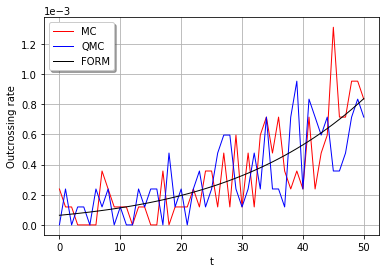

In [17]:
g = Graph()
g.setAxes(True)
g.setGrid(True)
c = Curve(times, [[p] for p in values_MC])
g.add(c)
c = Curve(times, [[p] for p in values_QMC])
g.add(c)
c = Curve(times, [[p] for p in values_FORM])
g.add(c)
g.setLegends(["MC", "QMC", "FORM"])
g.setColors(["red", "blue", 'black'])
g.setLegendPosition("topleft")
g.setXTitle("t")
g.setYTitle("Outcrossing rate")
Show(g)